In [1]:
# libs and init
import os
import cv2
import numpy as np
import pytesseract
from spellchecker import SpellChecker
from PIL import Image
from matplotlib import pyplot as plt

In [11]:
# Image Path specifications
IMG = "/home/krushang/radhey/personal/college/Doc-Scanner-Project/test/printed_guj.png"
OUTPUT_DIR = "./out"

In [12]:
# helper function to see image output

def show(window_name, img, wait=True, max_width=1000, max_height=800):
    h, w = img.shape[:2]
    scale = min(max_width / w, max_height / h, 1.0)
    if scale < 1.0:
        new_w, new_h = int(w * scale), int(h * scale)
        img = cv2.resize(img, (new_w, new_h), interpolation=cv2.INTER_AREA)

    plt.figure(figsize=(10, 8))
    if len(img.shape) == 2:  # grayscale
        plt.imshow(img, cmap='gray')
    else:  # color
        plt.imshow(cv2.cvtColor(img, cv2.COLOR_BGR2RGB))
    plt.title(window_name)
    plt.axis('off')
    plt.show()

In [13]:
# preproceding pip line
def preprocess_for_handwriting(image, mode='normal', threshold_type='adaptive'):
    print("Pre Processing Pipline")

    # Convert to grayscale
    gray = cv2.cvtColor(image, cv2.COLOR_BGR2GRAY)
    print("Grayscale")
    show("1. Grayscale", gray)

    # Increase contrast using CLAHE
    clahe = cv2.createCLAHE(clipLimit=3.0, tileGridSize=(8, 8))
    contrast_enhanced = clahe.apply(gray)
    print("CLAHE Contrast Enhancement")
    show("2. Contrast Enhanced", contrast_enhanced)

    # Denoise while preserving edges (critical for handwriting)
    denoised = cv2.fastNlMeansDenoising(
        contrast_enhanced, None, h=10, templateWindowSize=7, searchWindowSize=21
    )
    print("Denoising")
    show("3. Denoised", denoised)

    # Apply bilateral filter to smooth while keeping edges
    bilateral = cv2.bilateralFilter(denoised, 9, 75, 75)
    print("Bilateral Filter")
    show("4. Bilateral Filter", bilateral)

    # Apply chosen thresholding method
    print(f"Applying {threshold_type.upper()} thresholding...")

    adaptive_thresh = None
    normal_thresh = None
    thresh = None

    if threshold_type == 'adaptive':
        adaptive_thresh = cv2.adaptiveThreshold(
            bilateral, 255, cv2.ADAPTIVE_THRESH_GAUSSIAN_C,
            cv2.THRESH_BINARY, 21, 10
        )
        thresh = adaptive_thresh
        print("Adaptive Thresholding Applied")
        show("5. Adaptive Threshold", thresh)

    elif threshold_type == 'normal':
        _, normal_thresh = cv2.threshold(
            bilateral, 0, 255, cv2.THRESH_BINARY + cv2.THRESH_OTSU
        )
        thresh = normal_thresh
        print("Normal (Otsu) Thresholding Applied")
        show("5. Normal (Otsu) Threshold", thresh)

    else:
        print("Invalid threshold_type; defaulting to Adaptive.")
        thresh = cv2.adaptiveThreshold(
            bilateral, 255, cv2.ADAPTIVE_THRESH_GAUSSIAN_C,
            cv2.THRESH_BINARY, 21, 10
        )
        show("5. Adaptive Threshold (Default)", thresh)

    # Morphological operations for thin/thick character adjustment
    print("Morphological Operations for Thickness Adjustment")
    if mode == 'thin':
        kernel_open = cv2.getStructuringElement(cv2.MORPH_ELLIPSE, (1, 1))
        kernel_close = cv2.getStructuringElement(cv2.MORPH_ELLIPSE, (2, 2))
    elif mode == 'thick':
        kernel_open = cv2.getStructuringElement(cv2.MORPH_ELLIPSE, (3, 3))
        kernel_close = cv2.getStructuringElement(cv2.MORPH_ELLIPSE, (4, 4))
    else:
        kernel_open = cv2.getStructuringElement(cv2.MORPH_ELLIPSE, (2, 2))
        kernel_close = cv2.getStructuringElement(cv2.MORPH_ELLIPSE, (3, 3))

    morph_open = cv2.morphologyEx(thresh, cv2.MORPH_OPEN, kernel_open, iterations=1)
    morph_cleaned = cv2.morphologyEx(morph_open, cv2.MORPH_CLOSE, kernel_close, iterations=1)
    show("6. Morphological Cleanup", morph_cleaned)

    # Invert if needed (text should be black on white)
    if np.mean(morph_cleaned) > 127:
        morph_cleaned = cv2.bitwise_not(morph_cleaned)

    # Upscale for better OCR (handwriting needs higher resolution)
    h, w = morph_cleaned.shape
    scale_factor = 2
    if h < 1500:
        scale_factor = 3

    upscaled = cv2.resize(
        morph_cleaned,
        None,
        fx=scale_factor,
        fy=scale_factor,
        interpolation=cv2.INTER_CUBIC,
    )
    print("Upscaling")
    show("7. Upscaled (Final)", upscaled)

    return image, bilateral, upscaled


def preprocessing(img_path, out_dir="./out", mode='normal', threshold_type='adaptive'):
    os.makedirs(out_dir, exist_ok=True)

    print(f"Loading IMAGE: {img_path}")
    image = cv2.imread(img_path)
    if image is None:
        raise RuntimeError(f"Cannot read image: {img_path}")

    # For handwriting, always use specialized preprocessing
    return preprocess_for_handwriting(image, mode, threshold_type)

In [14]:
# contour detection
def order_points(pts):
    rect = np.zeros((4, 2), dtype="float32")
    s = pts.sum(axis=1)
    rect[0] = pts[np.argmin(s)]
    rect[2] = pts[np.argmax(s)]
    diff = np.diff(pts, axis=1)
    rect[1] = pts[np.argmin(diff)]
    rect[3] = pts[np.argmax(diff)]
    return rect


def manual_corner_selection(image):
    points = []
    clone = image.copy()

    def click_event(event, x, y, flags, params):
        if event == cv2.EVENT_LBUTTONDOWN and len(points) < 4:
            points.append([x, y])
            cv2.circle(clone, (x, y), 10, (0, 0, 255), -1)
            cv2.putText(
                clone,
                str(len(points) - 1),
                (x, y),
                cv2.FONT_HERSHEY_SIMPLEX,
                1,
                (255, 0, 0),
                2,
            )
            if len(points) > 1:
                cv2.line(clone, tuple(points[-2]), tuple(points[-1]), (0, 255, 0), 2)
            if len(points) == 4:
                cv2.line(clone, tuple(points[-1]), tuple(points[0]), (0, 255, 0), 2)
            cv2.imshow("Select 4 Corners", clone)

    cv2.namedWindow("Select 4 Corners")
    cv2.setMouseCallback("Select 4 Corners", click_event)
    cv2.imshow("Select 4 Corners", clone)

    print("Click 4 corners in order: top-left, top-right, bottom-right, bottom-left")
    print("Press any key when done...")

    cv2.waitKey(0)
    cv2.destroyWindow("Select 4 Corners")

    if len(points) == 4:
        return np.array(points, dtype=np.float32)
    return None


def contour_detection(image, processed):
    h, w = image.shape[:2]

    print("\nContour Detection Options:")
    print("1. Auto-detect document edges")
    print("2. Use whole image")
    print("3. Manual corner selection")

    choice = input("Enter choice (1-3): ").strip()

    if choice == "2":
        print("Using whole image...")
        doc_contour = (
            np.array([[0, 0], [w - 1, 0], [w - 1, h - 1], [0, h - 1]], dtype=np.float32)
            .reshape(4, 1, 2)
            .astype(np.int32)
        )
        return doc_contour

    elif choice == "3":
        doc_contour = manual_corner_selection(image)
        if doc_contour is not None:
            doc_contour = order_points(doc_contour.reshape(4, 2))
            doc_contour = doc_contour.reshape(4, 1, 2).astype(np.int32)
            return doc_contour
        else:
            print("Manual selection failed. Using whole image.")
            doc_contour = (
                np.array(
                    [[0, 0], [w - 1, 0], [w - 1, h - 1], [0, h - 1]], dtype=np.float32
                )
                .reshape(4, 1, 2)
                .astype(np.int32)
            )
            return doc_contour

    # Auto-detect (option 1)
    edges = cv2.Canny(processed, 50, 150)
    kernel = cv2.getStructuringElement(cv2.MORPH_RECT, (5, 5))
    edges = cv2.dilate(edges, kernel, iterations=2)

    contours, _ = cv2.findContours(edges, cv2.RETR_LIST, cv2.CHAIN_APPROX_SIMPLE)

    if contours:
        contours = sorted(contours, key=cv2.contourArea, reverse=True)[:10]

        for contour in contours:
            peri = cv2.arcLength(contour, True)
            approx = cv2.approxPolyDP(contour, 0.02 * peri, True)

            if len(approx) == 4:
                doc_contour = order_points(approx.reshape(4, 2))
                doc_contour = doc_contour.reshape(4, 1, 2).astype(np.int32)

                # Show detected contour
                contour_img = image.copy()
                cv2.drawContours(contour_img, [doc_contour], -1, (0, 255, 0), 3)
                show("Auto-detected Contour", contour_img)

                return doc_contour

    print("Auto-detection failed. Using whole image.")
    doc_contour = (
        np.array([[0, 0], [w - 1, 0], [w - 1, h - 1], [0, h - 1]], dtype=np.float32)
        .reshape(4, 1, 2)
        .astype(np.int32)
    )
    return doc_contour

In [15]:
# Prespactive Transformation 
def perspective_transform(image, contour):
    rect = order_points(contour.reshape(4, 2))
    (tl, tr, br, bl) = rect

    widthA = np.sqrt(((br[0] - bl[0]) ** 2) + ((br[1] - bl[1]) ** 2))
    widthB = np.sqrt(((tr[0] - tl[0]) ** 2) + ((tr[1] - tl[1]) ** 2))
    maxWidth = max(int(widthA), int(widthB))

    heightA = np.sqrt(((tr[0] - br[0]) ** 2) + ((tr[1] - br[1]) ** 2))
    heightB = np.sqrt(((tl[0] - bl[0]) ** 2) + ((tl[1] - bl[1]) ** 2))
    maxHeight = max(int(heightA), int(heightB))

    dst = np.array(
        [[0, 0], [maxWidth - 1, 0], [maxWidth - 1, maxHeight - 1], [0, maxHeight - 1]],
        dtype="float32",
    )

    M = cv2.getPerspectiveTransform(rect, dst)
    warped = cv2.warpPerspective(image, M, (maxWidth, maxHeight))

    show("Warped Document", warped)
    return warped

In [16]:
def select_language():
    print("\nSelect language for OCR:")
    print("1. English")
    print("2. Hindi")
    print("3. Gujarati")

    choice = input("Enter choice (1-3): ").strip()
    language_map = {
        "1": ("eng", "English"),
        "2": ("hin", "Hindi"),
        "3": ("guj", "Gujarati"),
    }

    if choice in language_map:
        return language_map[choice]
    else:
        print("Invalid choice. Using English by default.")
        return ("eng", "English")


def text_extraction(image, lang_code="eng", lang_name="English", output_file="extracted_text.txt"):
    print(f"\nPerforming OCR ({lang_name})...")

    # Ensure grayscale
    if len(image.shape) == 3:
        gray = cv2.cvtColor(image, cv2.COLOR_BGR2GRAY)
    else:
        gray = image.copy()

    # Auto-invert if background is dark (for better OCR)
    if np.mean(gray) < 100:
        gray = cv2.bitwise_not(gray)

    # Multiple OCR configurations for better results
    ocr_configs = [
        ("--oem 1 --psm 6", "Uniform text block"),
        ("--oem 1 --psm 4", "Single column text"),
        ("--oem 1 --psm 3", "Fully automatic layout"),
        ("--oem 1 --psm 11", "Sparse text"),
    ]

    results = []

    for config, description in ocr_configs:
        try:
            print(f"  Trying: {description}...")

            data = pytesseract.image_to_data(
                gray, config=f"{config} -l {lang_code}",
                output_type=pytesseract.Output.DICT
            )

            confidences = [int(c) for c in data["conf"] if str(c).isdigit() and int(c) > 0]
            avg_confidence = sum(confidences) / len(confidences) if confidences else 0

            text = pytesseract.image_to_string(gray, config=f"{config} -l {lang_code}")
            text = text.replace("\x0c", "").strip()

            word_count = len([w for w in text.split() if len(w) > 2])
            quality_score = avg_confidence * (1 + word_count / 100)

            results.append({
                "text": text,
                "confidence": avg_confidence,
                "quality": quality_score,
                "method": description,
            })

            print(f"    Confidence: {avg_confidence:.1f}%, Words: {word_count}, Score: {quality_score:.1f}")

        except Exception as e:
            print(f"    Failed: {e}")
            continue

    if not results:
        print("All OCR attempts failed!")
        return "", 0, "None"

    best_result = max(results, key=lambda x: x["quality"])

    # Print a preview of extracted text
    print("\n" + "=" * 60)
    print("EXTRACTED TEXT PREVIEW:")
    print("=" * 60)
    print(best_result["text"][:500] if best_result["text"] else "[No text detected]")
    print("=" * 60)

    # Save extracted text to file
    with open(output_file, "w", encoding="utf-8") as f:
        f.write("AI Powered Document Scanner - OCR Result\n")
        f.write("=" * 60 + "\n")
        f.write(f"Language: {lang_name}\n")
        f.write(f"OCR Method: {best_result['method']}\n")
        f.write(f"Confidence: {best_result['confidence']:.2f}%\n\n")
        f.write("Extracted Text:\n")
        f.write("-" * 60 + "\n")
        f.write(best_result["text"])

    print(f"\nExtracted text saved to: {output_file}")

    return best_result["text"], best_result["confidence"], best_result["method"]


In [17]:

def ai_spell_correction(text, lang_code):
    if "eng" not in lang_code:
        print("Spell checking only available for English text.")
        return text

    spell = SpellChecker()
    lines = text.split("\n")
    corrected_lines = []
    corrections_made = 0

    print("\nPerforming AI Spell Correction...")

    for line in lines:
        if not line.strip():
            corrected_lines.append(line)
            continue

        words = line.split()
        corrected_words = []

        for word in words:
            prefix, suffix = "", ""
            clean_word = word

            while clean_word and not clean_word[0].isalnum():
                prefix += clean_word[0]
                clean_word = clean_word[1:]

            while clean_word and not clean_word[-1].isalnum():
                suffix = clean_word[-1] + suffix
                clean_word = clean_word[:-1]

            if clean_word and clean_word.isalpha() and len(clean_word) > 2:
                correction = spell.correction(clean_word.lower())
                if correction and correction != clean_word.lower():
                    if clean_word[0].isupper():
                        correction = correction.capitalize()
                    corrected_words.append(prefix + correction + suffix)
                    corrections_made += 1
                else:
                    corrected_words.append(word)
            else:
                corrected_words.append(word)

        corrected_lines.append(" ".join(corrected_words))

    print(f"Corrections made: {corrections_made}")
    return "\n".join(corrected_lines)

In [18]:
def save_processed_image(image, filename):
    output_path = os.path.join(OUTPUT_DIR, filename)
    cv2.imwrite(output_path, image)
    print(f"Saved: {output_path}")
    return output_path


def enhance_image_quality(image):
    if len(image.shape) == 2:
        image_rgb = cv2.cvtColor(image, cv2.COLOR_GRAY2BGR)
    else:
        image_rgb = image

    lab = cv2.cvtColor(image_rgb, cv2.COLOR_BGR2LAB)
    l, a, b = cv2.split(lab)
    clahe = cv2.createCLAHE(clipLimit=2.0, tileGridSize=(8, 8))
    l = clahe.apply(l)
    enhanced = cv2.merge([l, a, b])
    enhanced = cv2.cvtColor(enhanced, cv2.COLOR_LAB2BGR)

    kernel = np.array([[0, -1, 0], [-1, 5, -1], [0, -1, 0]])
    enhanced = cv2.filter2D(enhanced, -1, kernel)

    return enhanced


def convert_to_high_quality_jpg(image, output_filename):
    output_path = os.path.join(OUTPUT_DIR, output_filename)
    enhanced = enhance_image_quality(image)
    pil_image = Image.fromarray(cv2.cvtColor(enhanced, cv2.COLOR_BGR2RGB))
    pil_image.save(output_path, "JPEG", quality=95, optimize=True, dpi=(300, 300))
    print(f"High-quality JPG saved: {output_path}")
    return output_path


def convert_image_to_pdf(image, output_filename):
    output_path = os.path.join(OUTPUT_DIR, output_filename)
    enhanced = enhance_image_quality(image)
    pil_image = Image.fromarray(cv2.cvtColor(enhanced, cv2.COLOR_BGR2RGB))
    pil_image.save(output_path, "PDF", resolution=300.0, quality=95)
    print(f"PDF saved: {output_path}")
    return output_path


def save_text_results(text, original_text, lang_name, method, confidence, output_file="extracted_text.txt"):
    output_path = os.path.join(OUTPUT_DIR, output_file)
    with open(output_path, "w", encoding="utf-8") as f:
        f.write("=" * 60 + "\n")
        f.write("HANDWRITTEN TEXT EXTRACTION RESULTS\n")
        f.write("=" * 60 + "\n\n")
        f.write(f"Language: {lang_name}\n")
        f.write(f"OCR Method: {method}\n")
        f.write(f"Confidence: {confidence:.2f}%\n")
        f.write("\n" + "-" * 60 + "\n")
        f.write("EXTRACTED TEXT:\n")
        f.write("-" * 60 + "\n\n")
        f.write(text)

        if original_text != text:
            f.write("\n\n" + "-" * 60 + "\n")
            f.write("ORIGINAL (BEFORE SPELL CHECK):\n")
            f.write("-" * 60 + "\n\n")
            f.write(original_text)

    print(f"\nResults saved to: {output_path}")
    return output_path

AI POWERED DOCUMENT SCANNER WITH OCR

Select preprocessing mode:
1. Normal
2. Thin handwriting
3. Thick handwriting


Enter choice (1-3):  2



Select thresholding method:
1. Adaptive Thresholding (recommended for uneven lighting)
2. Normal (Otsu) Thresholding


Enter choice (1-2):  1


Loading IMAGE: /home/krushang/radhey/personal/college/Doc-Scanner-Project/test/printed_guj.png
Pre Processing Pipline
Grayscale


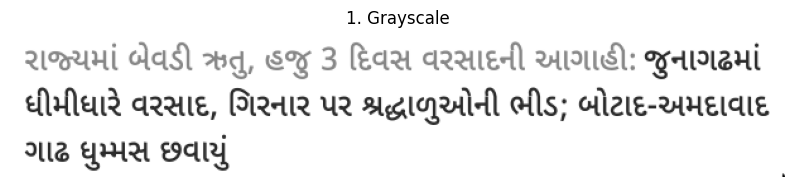

CLAHE Contrast Enhancement


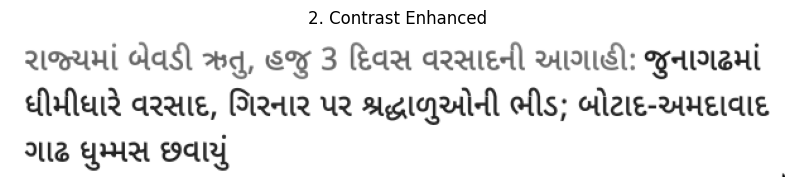

Denoising


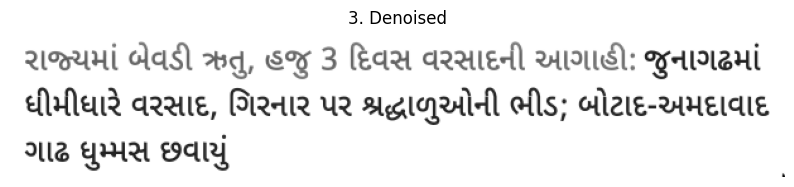

Bilateral Filter


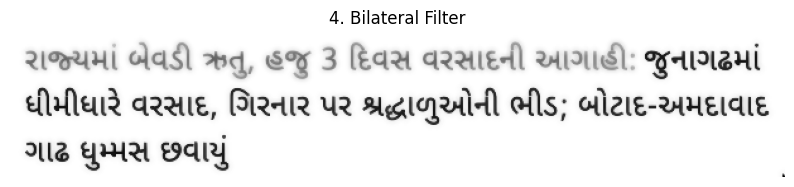

Applying ADAPTIVE thresholding...
Adaptive Thresholding Applied


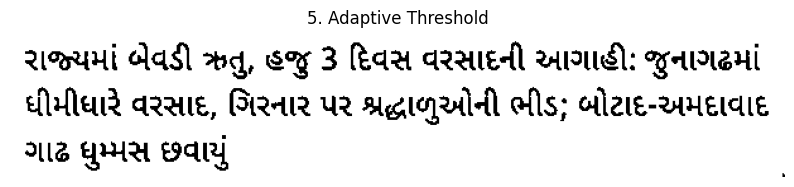

Morphological Operations for Thickness Adjustment


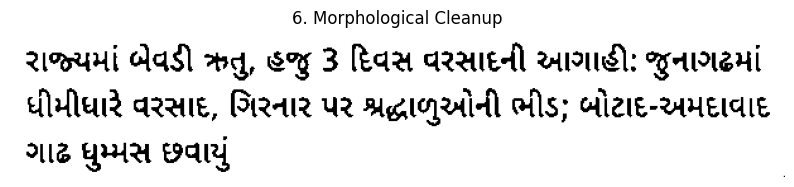

Upscaling


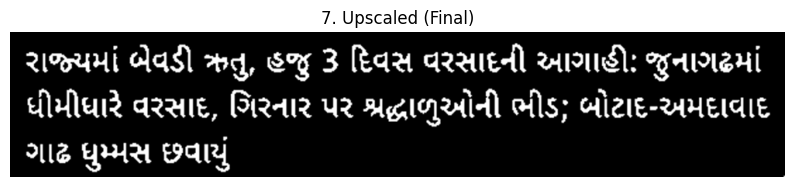

Saved: ./out/01_preprocessed.png

Contour Detection Options:
1. Auto-detect document edges
2. Use whole image
3. Manual corner selection


Enter choice (1-3):  2


Using whole image...
Saved: ./out/02_final_ocr_ready.png


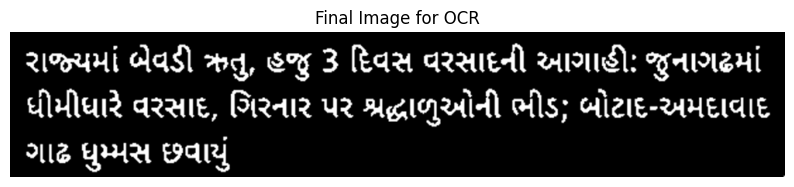


Select language for OCR:
1. English
2. Hindi
3. Gujarati


Enter choice (1-3):  3



Performing OCR (Gujarati)...
  Trying: Uniform text block...
    Confidence: 94.6%, Words: 17, Score: 110.6
  Trying: Single column text...
    Confidence: 94.6%, Words: 17, Score: 110.6
  Trying: Fully automatic layout...
    Confidence: 94.6%, Words: 17, Score: 110.6
  Trying: Sparse text...
    Confidence: 94.6%, Words: 17, Score: 110.6

EXTRACTED TEXT PREVIEW:
રાજ્યમાં બેવડી ત્રકતુ, હજુ 3 દિવસ વરસાદની આગાહી: જુનાગઢમાં
ધીમીધારે વરસાદ, ગિરનાર પર શ્રદ્ધાળુઓની ભીડ; બોટાદ-અમદાવાદ
ગાઢ ધુમ્મસ છવાયું

Extracted text saved to: ./out/extracted_text.txt

GENERATING OUTPUT FILES
High-quality JPG saved: ./out/scanned_document.jpg
PDF saved: ./out/scanned_document.pdf

PROCESSING COMPLETE!

Output directory: ./out/

Generated files:
  ✓ Preprocessed image: 01_preprocessed.png
  ✓ OCR-ready image: 02_final_ocr_ready.png
  ✓ High-quality JPG: scanned_document.jpg
  ✓ PDF: scanned_document.pdf
  ✓ Extracted text: extracted_text.txt

OCR Method Used: Uniform text block
OCR Quality: 94.6% confidence

In [19]:
def main():
    os.makedirs(OUTPUT_DIR, exist_ok=True)

    print("=" * 60)
    print("AI POWERED DOCUMENT SCANNER WITH OCR")
    print("=" * 60)

    print("\nSelect preprocessing mode:")
    print("1. Normal")
    print("2. Thin handwriting")
    print("3. Thick handwriting")

    mode_choice = input("Enter choice (1-3): ").strip()
    mode_map = {"1": "normal", "2": "thin", "3": "thick"}
    mode = mode_map.get(mode_choice, "normal")

    print("\nSelect thresholding method:")
    print("1. Adaptive Thresholding (recommended for uneven lighting)")
    print("2. Normal (Otsu) Thresholding")

    thresh_choice = input("Enter choice (1-2): ").strip()
    thresh_map = {"1": "adaptive", "2": "normal"}
    threshold_type = thresh_map.get(thresh_choice, "adaptive")

    # Step 1: Preprocessing
    image, processed, final_preprocessed = preprocessing(IMG, mode=mode, threshold_type=threshold_type)
    save_processed_image(final_preprocessed, "01_preprocessed.png")

    # Step 2: Contour detection
    contour = contour_detection(image, processed)

    # Step 3: Perspective transform
    if contour is not None:
        h, w = image.shape[:2]
        full_image_contour = np.array([[0, 0], [w - 1, 0], [w - 1, h - 1], [0, h - 1]], dtype=np.float32)
        contour_reshaped = contour.reshape(4, 2)
        if not np.allclose(contour_reshaped, full_image_contour, atol=20):
            warped = perspective_transform(image, contour)
            warped_preprocessed = perspective_transform(final_preprocessed, contour)
            final_image = warped
            final_for_ocr = warped_preprocessed
        else:
            final_image = image
            final_for_ocr = final_preprocessed
    else:
        final_image = image
        final_for_ocr = final_preprocessed

    save_processed_image(final_for_ocr, "02_final_ocr_ready.png")
    show("Final Image for OCR", final_for_ocr)

    # Step 4: Language selection and OCR
    lang_code, lang_name = select_language()
    text, confidence, method = text_extraction(
        final_for_ocr,
        lang_code,
        lang_name,
        os.path.join(OUTPUT_DIR, "extracted_text.txt"),
    )

    # Step 5: Save output formats
    print("\n" + "=" * 60)
    print("GENERATING OUTPUT FILES")
    print("=" * 60)

    jpg_path = convert_to_high_quality_jpg(final_image, "scanned_document.jpg")
    pdf_path = convert_image_to_pdf(final_image, "scanned_document.pdf")

    # Summary
    print("\n" + "=" * 60)
    print("PROCESSING COMPLETE!")
    print("=" * 60)
    print(f"\nOutput directory: {OUTPUT_DIR}/")
    print("\nGenerated files:")
    print("  ✓ Preprocessed image: 01_preprocessed.png")
    print("  ✓ OCR-ready image: 02_final_ocr_ready.png")
    print("  ✓ High-quality JPG: scanned_document.jpg")
    print("  ✓ PDF: scanned_document.pdf")
    print("  ✓ Extracted text: extracted_text.txt")
    print(f"\nOCR Method Used: {method}")
    print(f"OCR Quality: {confidence:.1f}% confidence")
    print(f"Extracted Text Length: {len(text)} characters")

    print("\nExtracted Text (Full):")
    print("=" * 60)
    print(text)
    print("=" * 60)


if __name__ == "__main__":
    main()
